[INFO] loading images...


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
111/111 [==============================] - 233s 2s/step - loss: 0.3141 - accuracy: 0.8779 - val_loss: 0.2164 - val_accuracy: 0.9181
Epoch 2/20
111/111 [==============================] - 219s 2s/step - loss: 0.2126 - accuracy: 0.9227 - val_loss: 0.1811 - val_accuracy: 0.9327
Epoch 3/20
111/111 [==============================] - 219s 2s/step - loss: 0.1776 - accuracy: 0.9266 - val_loss: 0.1785 - val_accuracy: 0.9327
Epoch 4/20
111/111 [==============================] - 225s 2s/step - loss: 0.1576 - accuracy: 0.9394 - val_loss: 0.1627 - val_accuracy: 0.9394
Epoch 5/20
111/111 [==============================] - 242s 2s/step - loss: 0.1497 - accuracy: 0.9419 - val_loss: 0.1562 - val_accuracy: 0.9360
Epoch 6/20
111/111 [==============================] - 220s 2s/step - loss: 0.1391 - accuracy: 0.9456 - val_loss: 0.1407 - val_accuracy: 0.9405
Epoch 7/20
111/111 [==============================] - 288s 3s/step - loss: 0.1250 - accuracy

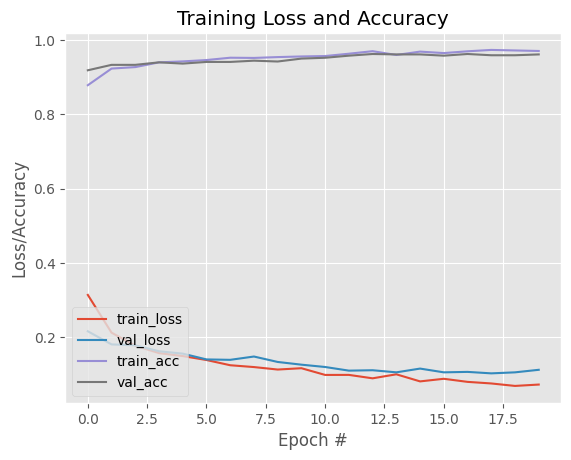

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# khởi tạo tốc độ học ban đầu, epochs và batch_size

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"/content/drive/MyDrive/PBL5/final_data"
CATEGORIES = ["recycle", "unrecycle"]

# Lấy hình ảnh từ thư mục ở drive, sau đó khởi tạo danh sách và class image

print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

# Chuyển đổi nhãn từ chuỗi thành dạng one-hot encoding
# Chia data thành (trainX, testX, trainY, testY) tỉ lệ 0.8:0.2

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# Tăng độ đa dạng dữ liệu một lần nữa với ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Tải MobileNetV2 làm mô hình cơ sở, loại bỏcác tầng Fully Connected
# (FC) layers ở đầu mô hình

baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Xây dựng các tầng Fully Connected (FC) layers gồm
# AveragePooling2D, Flatten, Dense và Dropout

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Tạo một mô hình hoàn chỉnh bằng cách kết hợp mô hình cơ sở 
# và các tầng Fully Connected (FC) layers mới

model = Model(inputs=baseModel.input, outputs=headModel)

# Đóng băng các tầng của mô hình cơ sở để 
# chỉ huấn luyện các tầng mới được thêm vào

for layer in baseModel.layers:
    layer.trainable = False

## Train và xuất Model

print("[INFO] compiling model...")
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = tf.keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# phiên bản mới k có tham số decay, vốn là tham số giảm tốc độ học

opt = Adam(lr=INIT_LR)

# Sử dụng tối ưu hóa Adam và hàm mất mát binary_crossentropy để train mô hình
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# Đánh giá mô hình

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# Lấy nhãn có dự đoán cao nhất trong data test

predIdxs = np.argmax(predIdxs, axis=1)

# Báo cáo phân loại

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Lưu file model

print("[INFO] saving mask detector model...")
model.save("garbage.model", save_format="h5")

# Xuất đồ thị đánh giá loss và accurancy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
